# COCO BBOB

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import COCO

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LiftedBPC
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from experiments import run_experiment, ylim

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we work with an underlying Linear Dynamical System (LDS) with complex, nonconvex cost functions.

The states $\{x_t\}_{t}$ evolve with
$$x_{t+1} = \begin{cases}x_{t} + u_t & \text{predict_differences is True} \\
u_t & \text{else}\end{cases},$$
where `predict_differences` is set in the system hyperparameters.

The costs are denoted by $f(x_t, u_t)$ and given by problems in the COCO Black Box Optimization suite (http://numbbo.github.io/coco/), which are selected via `problem_idx`. An example cost function is given below (they can be multi-dimensional, but inputs are restricted to lie in $[-5, 5]^{dim}$).

WARNING (<class 'extravaganza.dynamical_systems.COCO'>): no `Stats` object provided, so a new one will be made.
registering running average of fs
LOG (<class 'extravaganza.dynamical_systems.COCO'>): initial state is [-0.65206975]
bbob_f005_i110_d10: a 10-dimensional single-objective problem (problem 1154 of suite "b'bbob'" with name "BBOB suite problem f5 instance 110 in 10D")


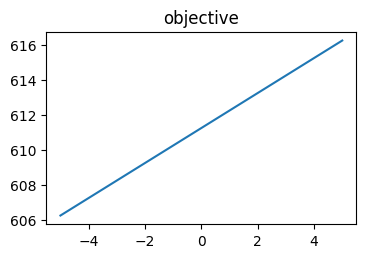

In [2]:
# things it breaks for:
#       304, 224 & 576 (lil wiggles), 2133 (this ones unfair), 1653 (sucks at wiggles), 1154 (straight line)
# things it looks interesting for:
#       1552 (large basin to explore), 1826 (large scale gives rly large fluctuations), 108 (zoom in on the basin)
# good nonconvex tests:
#       682 and 683 (two local mins, one at 0), 1129 (jaggedy), 1046 (two local mins), 2049

problem_idx = 1154

coco = COCO(problem_idx, 
            dim=1, 
            disturbance_type='none', 
            predict_differences=False, 
            seed=SYSTEM_SEED)
print(coco.problem)
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
ax.plot(coco.stats['gt_xs'], coco.stats['gt_fs'])
ax.set_title('objective')
plt.show()

## Hyperparameters

In [3]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 15000  # total timesteps
T0 = 8000  # number of timesteps to just sysid for our methods
reset_condition = lambda t: (t < T0 and t % 1500 == 0)# or (t > T0 and t % 6000 == 0)   # when to reset the system
wordy = True  # whether to print some things

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

dim = 1  # dimension of the optimization
problem_index = 1154
predict_differences = True

make_system = lambda : COCO(problem_index, dim, disturbance_type='none', predict_differences=predict_differences, seed=SYSTEM_SEED)

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

sysid_method = 'regression'
sysid_scale = 0.2

learned_lift_args = {
    'lift_lr': 0.004,
    'sysid_lr': 0.004,
    'cost_lr': 0.001,
    'depth': 12,
    'buffer_maxlen': int(1e6),
    'num_epochs': 150,
    'batch_size': 64,
    'seed': LIFTER_AND_SYSID_SEED
}

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 20  # controller memory length (# of w's to use on inference)
hh = 50  # history length of the cost/control histories
lift_dim = 10  # dimension to lift to

# m_update_rescaler = lambda : FIXED_RESCALE(alpha=0.00, beta=0)
# m0_update_rescaler = lambda : FIXED_RESCALE(alpha=0.001, beta=0)
# k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.00, beta=0)

m_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
m0_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.99))

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.01, 0.01, 0.01),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'T0': T0,
#     'bounds': (-0.1, 0.1),
    'initial_u': jnp.zeros(dim),
    'decay_scales': False,
    'use_tanh': False,
    'use_K_from_sysid': False,
    'seed': CONTROLLER_SEED
}

make_controllers = {
#     'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, dim, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, dim, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
#     'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, dim, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, dim, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, dim, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
}

## Plotting
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [4]:
def plot_coco(all_stats):
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot system stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)

        stats.plot(ax[2, 0], 'fs', label=method)
        stats.plot(ax[2, 1], 'median fs since last reset', label=method)

        stats.plot(ax[3, 0], '||A||_op', label=method)
        stats.plot(ax[3, 1], '||B||_F', label=method)
        stats.plot(ax[4, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 1], 'cost diffs', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend(); ylim(_ax, -20, 20)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, -3, 3)
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous costs'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('median costs since last reset'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[4, 1]; _ax.set_title('cost diffs'); _ax.legend()
    
    # plot the true COCO objective
    _ax = ax[1, 1]
    if stats.aggregated: _ax.plot(stats['gt_xs'][0], stats['gt_fs'][0])
    else: _ax.plot(stats['gt_xs'], stats['gt_fs'])
    _ax.set_title('objective'); _ax.set_xlim(-5, 5)
    pass

## actually run the thing :)

--------------------------------------------------
----------------- TRIAL 0 -----------------------
--------------------------------------------------

testing Learned Lift
WARNING (<class 'extravaganza.dynamical_systems.COCO'>): no `Stats` object provided, so a new one will be made.
registering running average of fs
LOG (<class 'extravaganza.dynamical_systems.COCO'>): initial state is [0.33238012]
WARNING (<class 'extravaganza.controllers.LiftedBPC'>): no `Stats` object provided, so a new one will be made.
registering running average of costs


  0%|                                                                                                       | 0/15000 [00:00<?, ?it/s]

reset!
state has been reset to [0.9323418]. it was [-0.44182062]


 10%|█████▍                                               | 1533/15000 [00:06<00:56, 236.59it/s, state=2.19, control=-.0554, cost=608]

reset!
state has been reset to [3.0002582]. it was [1.6947246]


 20%|██████████▌                                         | 3039/15000 [00:13<00:51, 230.03it/s, state=-3.94, control=0.0495, cost=602]

reset!
state has been reset to [-4.711581]. it was [7.1887636]


 30%|████████████████                                     | 4543/15000 [00:19<00:45, 230.97it/s, state=0.999, control=-.169, cost=607]

reset!
state has been reset to [-0.03031373]. it was [-5.06183]


 40%|█████████████████████▋                                | 6033/15000 [00:26<00:39, 226.58it/s, state=3.6, control=-.0314, cost=610]

reset!
state has been reset to [3.0054379]. it was [-7.219225]


 50%|██████████████████████████▌                          | 7531/15000 [00:33<00:33, 222.60it/s, state=2.68, control=-.0329, cost=609]

reset!
state has been reset to [3.108517]. it was [-5.096642]


 53%|████████████████████████████▏                        | 7989/15000 [00:35<00:31, 223.64it/s, state=-3.96, control=0.136, cost=602]

WARNING (<class 'extravaganza.controllers.LiftedBPC'>): note that we are only updating lifter during sysid phase
LOG (<class 'extravaganza.lifters.LearnedLift'>): training!
LOG (<class 'extravaganza.lifters.LearnedLift'>): 	mean loss for past 25 epochs was 0.0022109807934612034


 53%|████████████████████████████▏                        | 7989/15000 [00:50<00:31, 223.64it/s, state=-3.96, control=0.136, cost=602]

LOG (<class 'extravaganza.lifters.LearnedLift'>): 	mean loss for past 25 epochs was 6.24151666124817e-05
LOG (<class 'extravaganza.lifters.LearnedLift'>): 	mean loss for past 25 epochs was 7.142217305954546e-05
LOG (<class 'extravaganza.lifters.LearnedLift'>): 	mean loss for past 25 epochs was 7.448895848938264e-05
LOG (<class 'extravaganza.lifters.LearnedLift'>): 	mean loss for past 25 epochs was 7.799094164511189e-05
LOG (<class 'extravaganza.lifters.LearnedLift'>): 	mean loss for past 25 epochs was 7.01760312949773e-05
LOG (<class 'extravaganza.lifters.LearnedLift'>): 	mean loss for past 25 epochs was 8.599445049185305e-05
LOG (<class 'extravaganza.lifters.LearnedLift'>): ||A||_op = 1.02775239944458     ||B||_F 0.0014639550354331732


100%|███████████████████████████████████████████████| 15000/15000 [06:15<00:00, 39.97it/s, state=-40.7, control=0.00381, cost=1.87e+3]


<Figure size 640x480 with 0 Axes>

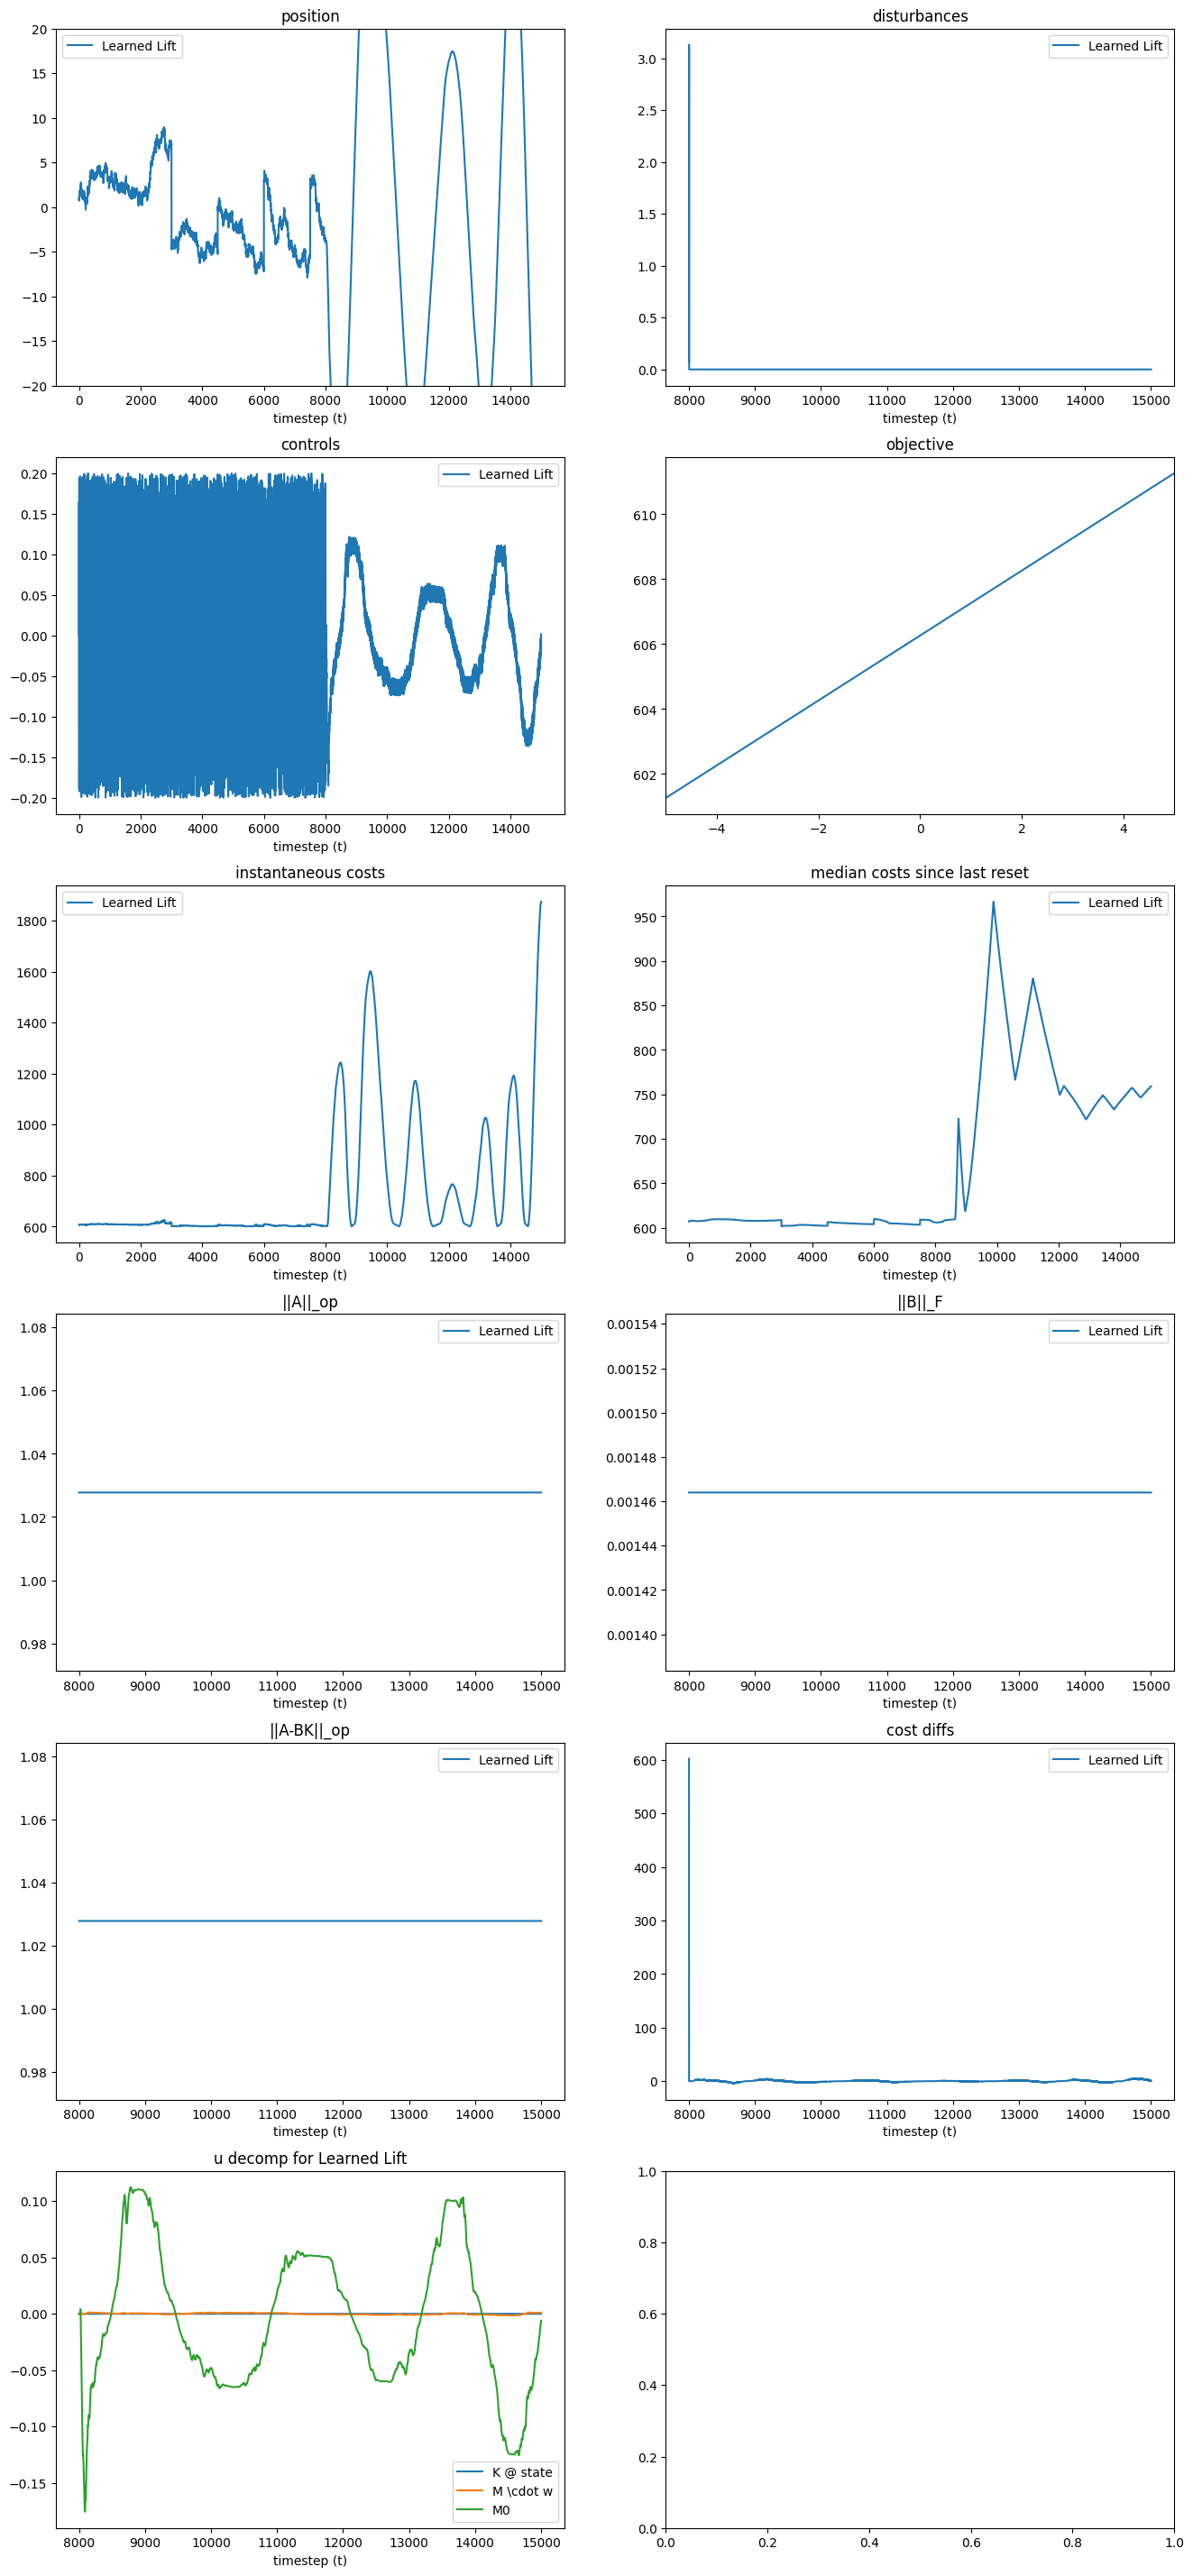

In [5]:
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'T': T,
    'reset_condition': reset_condition,
    'reset_seed': SYSTEM_SEED,
    'wordy': wordy,
    
    
}
stats = run_experiment(**experiment_args)
plot_coco(stats)
# plot_coco({k: s[25000:27000] for k, s in stats.items()})